In [1]:
import torch
from PIL import Image
from torch import optim,nn
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_image="model/54082.jpg"
output_filename = "model/output_filename_54082.jpg"

In [14]:
input_gt = Image.open("Set5/bird_GT.bmp").convert("RGB")
input_b = Image.open("Set5/bird_GT_scale_4.bmp").convert("RGB")

In [8]:
img = Image.open(input_image).convert('YCbCr')
y, cb, cr = img.split()
img_array=np.array(img)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1,64,(5,5),(1,1),(2,2))
        self.conv2 = nn.Conv2d(64,64,(3,3),(1,1),(1,1))
        self.conv3 = nn.Conv2d(64,32,(3,3),(1,1),(1,1))
        self.conv4 = nn.Conv2d(32,3**2,(3,3),(1,1),(1,1))
        self.pixel_shuffle = nn.PixelShuffle(3)
        self._initialize_weights()
    
    def forward(self,x):
        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        x=self.relu(self.conv3(x))
        x=self.pixel_shuffle(self.conv4(x))
        
        return x
    
    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight,init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight,init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)
        
model = Model()
model

Model(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [11]:
model = torch.load("model_epoch.pth")
img_to_tensor = ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])
model = model.cpu()
input = input.cpu()


In [12]:
out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
#out_img.save(output_filename)
print('output image saved to ', output_filename)

output image saved to  model/output_filename_54082.jpg


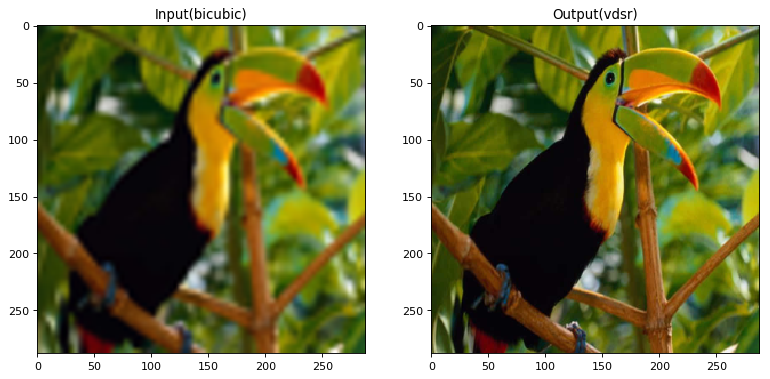

In [15]:
fig = plt.figure(figsize=(18, 16), dpi= 80)

inp_img = Image.fromarray(img_array,"YCbCr").convert("RGB")

ax = plt.subplot("132")
ax.imshow(input_b)
ax.set_title("Input(bicubic)")

ax = plt.subplot("133")
ax.imshow(input_gt)
ax.set_title("Output(vdsr)")
plt.show()